### Create conda enviroment with GPU support on the Tufts HPC Cluster

1) Create `gpu_env.yml` with the following packages

```yml
name: gpu_env
channels:
  - defaults
dependencies:
  - python==3.8
  - pip
  - git
  ## Scientific Computing
  - numpy>=1.18
  - scipy>=1.3
  ## Visualization
  - jupyter>=1.0
  - matplotlib>=3.1
  - seaborn>=0.11
  ## Data I/O
  - pandas>=0.22
  - dill>=0.2
  ## Machine Learning
  - scikit-learn>=1.1.0
```

2) Set up basic conda env without any torch or jax packages, via

```
conda env create -f gpu_env.yml
```

3) Install pytorch with specific cudatoolkit version

```
conda install pytorch==1.12.1 torchvision==0.13.1 torchaudio==0.12.1 cudatoolkit=11.3 -c pytorch
```

4) Install jax (if needed) with same specific cudatoolkit version

```
conda install -c "nvidia/label/cuda-11.3.1" cuda-nvcc
pip install "jax[cuda11_cudnn82]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
```

### Check if cuda is available

In [1]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# Note: GPUs need to be specifically requested through sbatch. Below is an
# example requesting an interactive session.
# srun -p preempt -t 7:00:00 -n 1 --mem=64g --gres=gpu:a100:1 --pty bash

cpu


### Example loading image from Chest X-Ray

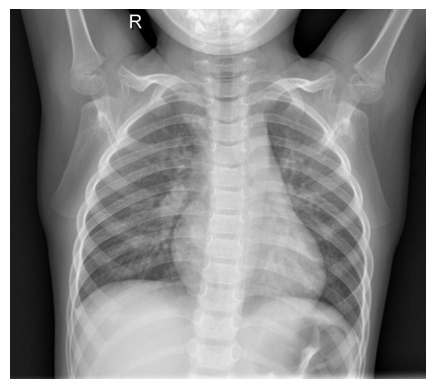

In [2]:
from torchvision.io import read_image
import matplotlib.pyplot as plt

path = '/cluster/tufts/hugheslab/eharve06/Chest_X-Ray/train/NORMAL/IM-0115-0001.jpeg'
image = read_image(path).float()
plt.imshow(image.permute(1, 2, 0).detach().numpy()/255, cmap='gray')
plt.axis('off')
plt.show()

### Example loading pretrained Vision Transformer (ViT)

In [3]:
import torchvision

# Load pretrained weights
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
# Load ViT with pretrained weights
model = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights(weights))

### Example replacing ViT classification heads

In [4]:
import torch.nn as nn

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
# Remove classification head
model.heads = Identity()
model.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_att

In [5]:
model.to(device)
# Note: If you are using GPUs make sure to load your model to the GPUs

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_att

### Example encoding image

In [6]:
# ViT expects normalized input of shape (batch_size, 3, 224, 224)
c, w, h = image.shape
print('Shape of original image: {}'.format(image.shape))
center_crop = torchvision.transforms.CenterCrop(min(w, h))
image = center_crop(image)
image = torchvision.transforms.functional.resize(image, size=(224, 224))
image = image.expand(3, 224, 224)
mean = torch.tensor([[[0.485]], [[0.456]], [[0.406]]])
std = torch.tensor([[[0.229]], [[0.224]], [[0.225]]])
image = ((image/255)-mean)/std
# Note: We normalized our input image with the mean and std of the pretrained 
# model see https://pytorch.org/vision/main/models/vision_transformer.html.
# Given enough training data, we should use the mean and std of our training
# data and not the mean and std of the pretrained model.
print('Shape of input image: {}'.format(image[None,:,:,:].shape))
encoded_image = model(image[None,:,:,:])
print('Shape of encoded image: {}'.format(encoded_image.shape))

Shape of original image: torch.Size([1, 1858, 2090])
Shape of input image: torch.Size([1, 3, 224, 224])
Shape of encoded image: torch.Size([1, 768])
